# Train an neural network for regression

- Watch this video https://lightning.ai/docs/pytorch/stable/starter/introduction.html

In [7]:
# Replace this test data with your data and adapt the code accordingly

import pandas as pd

df = pd.read_json(
    "https://raw.githubusercontent.com/kuennethgroup/materials_datasets/refs/heads/main/polymer_tendency_to_crystalize/polymers_tend_to_crystalize.json"
)
df

,smiles,property,value,fingerprint
0,[*]C[*],Xc,47.80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,[*]CC([*])C,Xc,44.47,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,[*]CC([*])CC,Xc,34.04,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,[*]CC([*])CCC,Xc,20.01,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[*]CC([*])CC(C)C,Xc,21.64,"[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
427,[*]C([*])(F)F,Xc,31.84,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
428,[*]C/C=C\C[*],Xc,25.58,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
429,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(N=Cc3ccc...,Xc,29.05,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
430,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(Cc3ccc(N...,Xc,21.74,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [2]:
import torch, torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import lightning as L

# --------------------------------
# Define a LightningModule by subclassing LightningModule
# A LightningModule is a subclass of nn.Module


class LitRegressor(L.LightningModule):
    def __init__(self):
        # -- Define your NN
        super().__init__()
        input_size = 2048
        self.l1 = nn.Sequential(nn.Linear(input_size, 300), nn.ReLU(), nn.Dropout(0.4))
        self.l2 = nn.Sequential(nn.Linear(300, 100), nn.ReLU(), nn.Dropout(0.4))
        self.l3 = nn.Sequential(nn.Linear(100, 1))

    def forward(self, x):
        # -- Define how to ho forward through your NN
        # forward defines the prediction/inference actions
        x = self.l3(self.l2(self.l1(x)))
        return x

    def training_step(self, batch, batch_idx):
        # -- Define how to do a training step
        # Split to input and output as you defined it in your dataloader
        x, y = batch
        # fog forward and get prediction
        x = self.forward(x)
        # compute loss
        y = y.view(x.size(0), -1)
        loss = F.mse_loss(y, x)
        # log the loss (for plotting later)
        self.log("train_loss", loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        # -- Define how to do a validation step (similar to raining)
        x, y = batch
        x = self.forward(x)
        y = y.view(x.size(0), -1)
        loss = F.mse_loss(x, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        # Define the optimize that you want to use
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

## Load data

In [3]:
import torch.utils.data as data_utils
import numpy as np
from sklearn.model_selection import train_test_split

# split
train, val = train_test_split(df, shuffle=True, random_state=123)

# Train
train_fps = torch.Tensor(np.stack(train["fingerprint"].values).astype(np.float32))
train_values = torch.Tensor(np.stack(train["value"].values).astype(np.float32))
train_data = data_utils.TensorDataset(train_fps, train_values)
train_loader = data_utils.DataLoader(train_data, batch_size=30, shuffle=False)

# Validation
val_fps = torch.Tensor(np.stack(val["fingerprint"].values).astype(np.float32))
val_values = torch.Tensor(np.stack(val["value"].values).astype(np.float32))
val_data = data_utils.TensorDataset(val_fps, val_values)
val_loader = data_utils.DataLoader(val_data, batch_size=30, shuffle=False)

# Test
# test loader, we use the same dataset as for val (for now); no values here
test_fps = torch.Tensor(np.stack(val["fingerprint"].values).astype(np.float32))
test_values = torch.Tensor(np.stack(val["value"].values).astype(np.float32))
test_loader = data_utils.DataLoader(test_fps, batch_size=30, shuffle=False)

# Train

In [4]:
from lightning.pytorch.callbacks import ModelSummary
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger


from pathlib import Path
import shutil


save_dir = Path("my_pytorch_model")
if save_dir.exists():
    shutil.rmtree(save_dir)

callbacks = [
    ModelCheckpoint(dirpath=save_dir, save_top_k=1, monitor="val_loss", verbose=True),
    ModelSummary(max_depth=-1),
    EarlyStopping(monitor="val_loss", mode="min", verbose=True),
]


regressor = LitRegressor()
trainer = L.Trainer(
    max_epochs=50,
    log_every_n_steps=1,
    val_check_interval=1,
    callbacks=callbacks,
    logger=[CSVLogger(".")],
)
trainer.fit(model=regressor, train_dataloaders=train_loader, val_dataloaders=val_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_f

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/chris/courses/ml-in-ms-st25/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.
/home/chris/courses/ml-in-ms-st25/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 1801.750
Epoch 0, global step 11: 'val_loss' reached 1801.75000 (best 1801.75000), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=0-step=11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 561.376 >= min_delta = 0.0. New best score: 1240.374
Epoch 1, global step 22: 'val_loss' reached 1240.37439 (best 1240.37439), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=1-step=22.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 77.308 >= min_delta = 0.0. New best score: 1163.066
Epoch 2, global step 33: 'val_loss' reached 1163.06604 (best 1163.06604), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=2-step=33.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 127.613 >= min_delta = 0.0. New best score: 1035.453
Epoch 3, global step 44: 'val_loss' reached 1035.45337 (best 1035.45337), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=3-step=44.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 115.687 >= min_delta = 0.0. New best score: 919.766
Epoch 4, global step 55: 'val_loss' reached 919.76636 (best 919.76636), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=4-step=55.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 120.900 >= min_delta = 0.0. New best score: 798.866
Epoch 5, global step 66: 'val_loss' reached 798.86591 (best 798.86591), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=5-step=66.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 109.267 >= min_delta = 0.0. New best score: 689.598
Epoch 6, global step 77: 'val_loss' reached 689.59845 (best 689.59845), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=6-step=77.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 90.016 >= min_delta = 0.0. New best score: 599.582
Epoch 7, global step 88: 'val_loss' reached 599.58246 (best 599.58246), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=7-step=88.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 66.823 >= min_delta = 0.0. New best score: 532.760
Epoch 8, global step 99: 'val_loss' reached 532.75983 (best 532.75983), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=8-step=99.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 44.111 >= min_delta = 0.0. New best score: 488.649
Epoch 9, global step 110: 'val_loss' reached 488.64880 (best 488.64880), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=9-step=110.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 33.458 >= min_delta = 0.0. New best score: 455.190
Epoch 10, global step 121: 'val_loss' reached 455.19040 (best 455.19040), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=10-step=121.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 24.660 >= min_delta = 0.0. New best score: 430.530
Epoch 11, global step 132: 'val_loss' reached 430.53043 (best 430.53043), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=11-step=132.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 13.435 >= min_delta = 0.0. New best score: 417.096
Epoch 12, global step 143: 'val_loss' reached 417.09555 (best 417.09555), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=12-step=143.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 11.571 >= min_delta = 0.0. New best score: 405.525
Epoch 13, global step 154: 'val_loss' reached 405.52493 (best 405.52493), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=13-step=154.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 23.519 >= min_delta = 0.0. New best score: 382.006
Epoch 14, global step 165: 'val_loss' reached 382.00565 (best 382.00565), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=14-step=165.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 3.967 >= min_delta = 0.0. New best score: 378.038
Epoch 15, global step 176: 'val_loss' reached 378.03824 (best 378.03824), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=15-step=176.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 12.431 >= min_delta = 0.0. New best score: 365.608
Epoch 16, global step 187: 'val_loss' reached 365.60770 (best 365.60770), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=16-step=187.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 15.094 >= min_delta = 0.0. New best score: 350.514
Epoch 17, global step 198: 'val_loss' reached 350.51367 (best 350.51367), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=17-step=198.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 2.733 >= min_delta = 0.0. New best score: 347.781
Epoch 18, global step 209: 'val_loss' reached 347.78064 (best 347.78064), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=18-step=209.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 2.894 >= min_delta = 0.0. New best score: 344.887
Epoch 19, global step 220: 'val_loss' reached 344.88693 (best 344.88693), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=19-step=220.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 9.128 >= min_delta = 0.0. New best score: 335.759
Epoch 20, global step 231: 'val_loss' reached 335.75903 (best 335.75903), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=20-step=231.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 2.081 >= min_delta = 0.0. New best score: 333.678
Epoch 21, global step 242: 'val_loss' reached 333.67847 (best 333.67847), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=21-step=242.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 4.579 >= min_delta = 0.0. New best score: 329.099
Epoch 22, global step 253: 'val_loss' reached 329.09903 (best 329.09903), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=22-step=253.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 264: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 1.429 >= min_delta = 0.0. New best score: 327.670
Epoch 24, global step 275: 'val_loss' reached 327.66956 (best 327.66956), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=24-step=275.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 286: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 4.696 >= min_delta = 0.0. New best score: 322.973
Epoch 26, global step 297: 'val_loss' reached 322.97318 (best 322.97318), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=26-step=297.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 308: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 11.204 >= min_delta = 0.0. New best score: 311.769
Epoch 28, global step 319: 'val_loss' reached 311.76880 (best 311.76880), saving model to '/home/chris/courses/ml-in-ms-st25/02_hack/my_pytorch_model/epoch=28-step=319.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 330: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 341: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 311.769. Signaling Trainer to stop.
Epoch 31, global step 352: 'val_loss' was not in top 1
Epoch 31, global step 352: 'val_loss' was not in top 1


## Plot

<Axes: xlabel='epoch,step'>

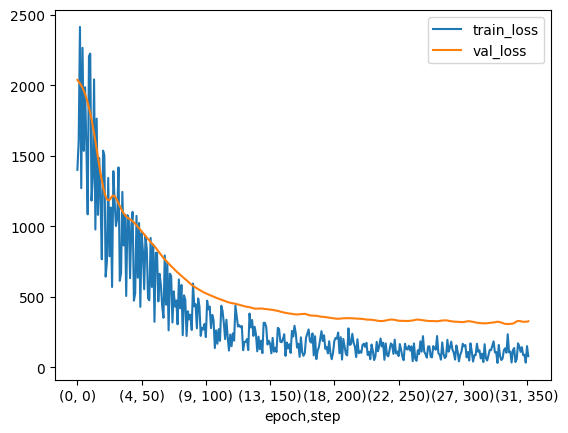

In [5]:
df_res = pd.read_csv(Path(trainer.logger.log_dir) / "metrics.csv")
df_res = df_res.set_index(["epoch", "step"])
df_res = pd.concat([df_res["train_loss"].dropna(), df_res["val_loss"].dropna()], axis=1)
df_res.plot()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-07-14 17:26:35.976189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752506795.988996  184958 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752506795.993218  184958 cuda_blas.cc:1418] Unab

Predicting: |          | 0/? [00:00<?, ?it/s]

rmse = 17.656977 [%]
r2 = 0.06448721885681152


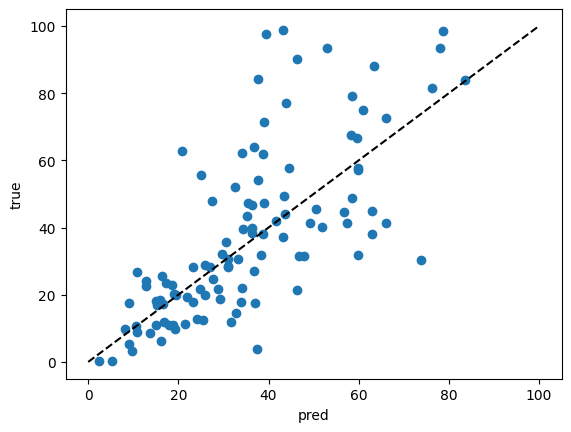

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score

fig, ax = plt.subplots()
best_regressor = LitRegressor.load_from_checkpoint(list(save_dir.glob("*.ckpt"))[0])

trainer = L.Trainer()
preds = trainer.predict(best_regressor, test_loader)
preds = torch.cat(preds).squeeze().numpy()

rmse = root_mean_squared_error(preds, test_values)
r2 = r2_score(preds, test_values)

ax.plot(preds, test_values, "o")
ax.plot([0, 100], [0, 100], "k--")
ax.set_ylabel("true")
ax.set_xlabel("pred")
print(f"{rmse = } [%]")
print(f"{r2 = }")